# Homework 0 Part 2

This is an individual assignment.

**Due: Thursday, September 8 @ 11:59pm**

---

## Custom Transformers

```scikit-learn``` offers many useful transformers, but you will likely need to write your own transformers for tasks such as custom cleanup operations or combining specific attributes.

To have your transformer working seamlessly with ```scikit-learn```, all you need to do is create a class and implement three methods: ```fit()``` (returning self), ```transform()```, and ```fit_transform()```.

You can get the last one for free by simply adding ```TransformerMixin``` as your base class. If you add ```BaseEstimator``` as a base class (and avoid ```*args``` and ```**kargs``` you will also get two extra methods (```get_params()``` and ```set_params()```) that will be useful for automatic hyperparameter tuning.

For example, for the dataset we discussed in lecture 3 (California housing prices), we can build a transformer to add the custom attributes as follows:

````python
from sklearn.base import BaseEstimator, TransformerMixin 

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__ (self, add_bedrooms_per_room=True): # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    def fit(self, X, y=None): 
        return self # nothing else to do 
    def transform(self, X): 
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
        population_per_household = X[:, population_ix] / X[:, households_ix] 
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix] 
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
````

This transformer can later be added to a ```scikit-learn``` pipeline like this:

````python
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler())]) 

housing_num_tr = num_pipeline.fit_transform(housing_num)
````

---

# Question 1 (7.5 points)

In this question, you will practice how to use HiPerGator and Git to maintain your code.

1. Open Open On-Demand [ood.rc.ufl.edu](ood.rc.ufl.edu) and create an interactive jupyter session with the following specifications: 1 CPU, 1 GPU (type = 'a100') and 4 GB of RAM. 

2. Create a symbolic link to map the class blue directory in your homepage. Attach a screenshot to show that this link has been created.

3. Navigate to your folder within the symbolic link you just created. Clone HW0-P2 in that folder. Attach a screenshot.

2.
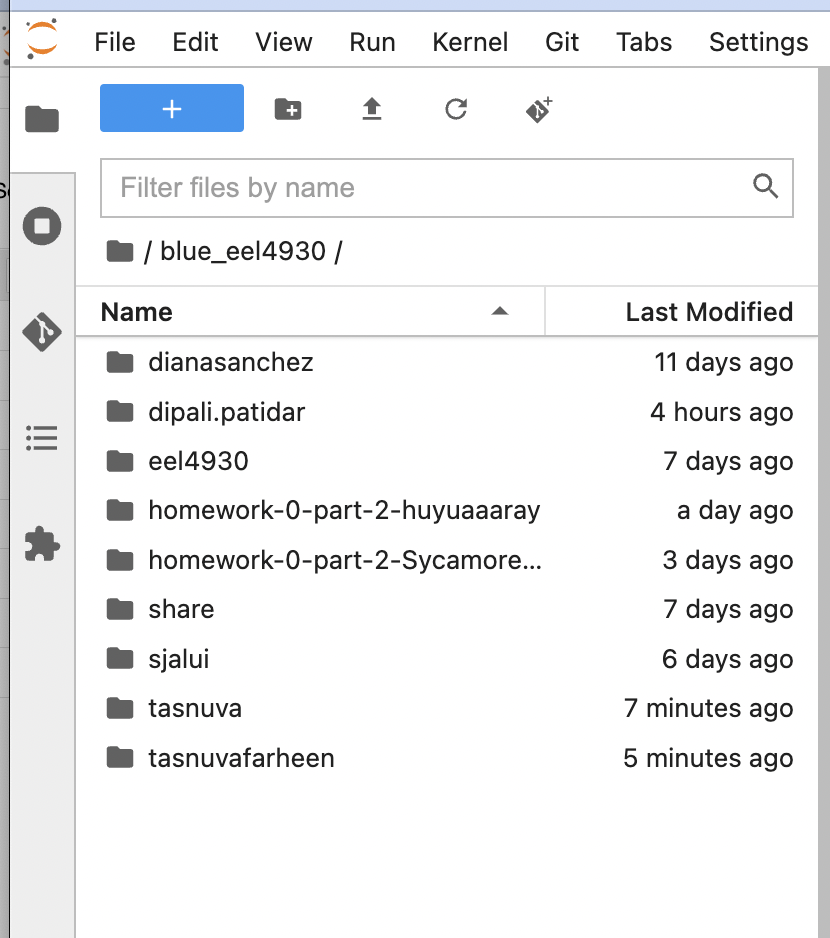

3.
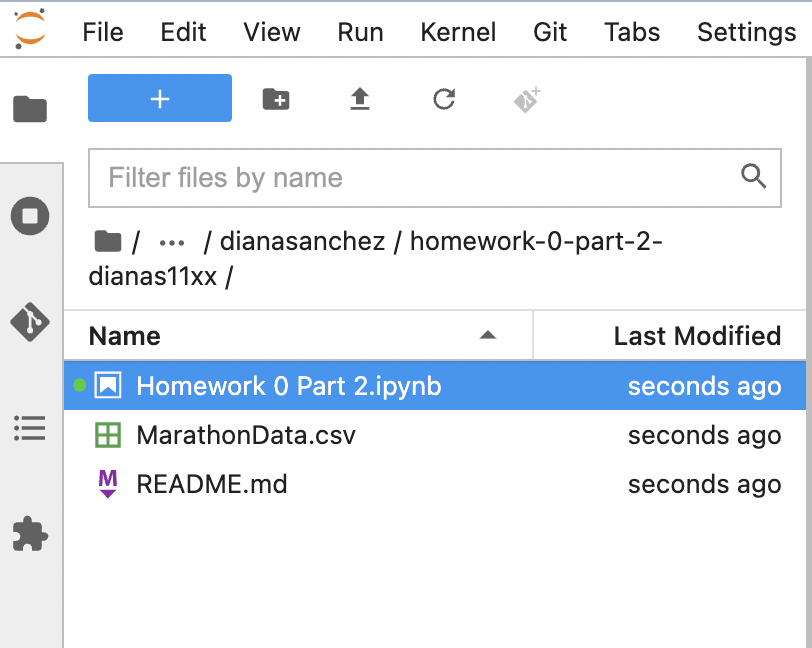

---

# Question 2 (40 points)

In this question, you will be working with the [marathon time predictions dataset](https://www.kaggle.com/datasets/girardi69/marathon-time-predictions).

### Attributes

* **id**: simple counter

* **Marathon**: the Marathon name where the data were extracted.

* **Name**: The athlete's name.

* **Category**: the sex and age group of a runner.
    * MAM Male Athletes under 40 years
    * WAM Women under 40 Years
    * M40 Male Athletes between 40 and 45 years

* **km4week**: This is the total number of kilometers run in the last 4 weeks before the marathon, marathon included. If, for example, the km4week is 100, the athlete has run 400 km in the four weeks before the marathon.

* **sp4week**: This is the average speed of the athlete in the last 4 training weeks. The average counts all the kilometers done, included the slow kilometers done before and after the training. A typical running session can be of 2km of slow running, then 12-14km of fast running, and finally other 2km of slow running. The average of the speed is this number, and with time this is one of the numbers that has to be refined.

* **cross training**: If the runner is also a cyclist, or a triathlete.

* **Wall21**: To acknowledge a good performance, as a marathoner, the first half marathon should be run with the same split of the second half. If, for example, I run the first half marathon in 1h30m, I must finish the marathon in 3h (for doing a good job). If I finish in 3h20m, I started too fast and I hit "the wall". My training history is, therefore, less valid, since I was not estimating my result.

* **Marathon time**: This is target value.

* **Category**: Categorical encoding of the target value. It groups in:
    * A results under 3h
    * B results between 3h and 3h20m
    * C results between 3h20m and 3h40m
    * D results between 3h40 and 4h

Answer the following questions:

1. Load the data with ```pandas```.

2. Are there missing samples? Determine which approach you are using to handle missing data. All justifications and reasoning must be included in a markdown cell.

3. Print the Pearson's correlation matrix and visualize the data. Which attribute has the largest predictive value to predict the marathon time?

4. Create a new attribute that computes the ratio between the ```km4week``` and ```sp4week```. FBuild a custom transformer to automate this feature extraction (see example at the top of this notebook).

5. Partition the data into training and test sets. If you use stratified partition, justify your answer.

6. Build a transformation pipeline with ```scikit-learn``` to encode any categorical attributes.

7. Build a transformation pipeline with ```scikit-learn``` to encode the numerical attributes. This pipeline should include your custom transformer built in step 4.

8. Build a transformation pipeline that combines both categorical and numerical attributes.

## P1)

In [3]:
import pandas as pd
marathon_data = pd.read_csv("MarathonData.csv");
marathon_data

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,NaN,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.5,12.258544,NaN,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.6,13.945055,NaN,1.36,2.74,A
...,...,...,...,...,...,...,...,...,...,...
82,83,Prague17,Stefano Vegliani,M55,50.0,10.830325,NaN,2.02,3.93,D
83,84,Prague17,Andrej Madliak,M40,33.6,10.130653,ciclista 3h,1.94,3.93,D
84,85,Prague17,Yoi Ohsako,M40,55.4,11.043189,NaN,1.94,3.94,D
85,86,Prague17,Simon Dunn,M45,33.2,11.066667,NaN,2.05,3.95,D


In [4]:
marathon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             87 non-null     int64  
 1   Marathon       87 non-null     object 
 2   Name           87 non-null     object 
 3   Category       81 non-null     object 
 4   km4week        87 non-null     float64
 5   sp4week        87 non-null     float64
 6   CrossTraining  13 non-null     object 
 7   Wall21         87 non-null     object 
 8   MarathonTime   87 non-null     float64
 9   CATEGORY       87 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 6.9+ KB


## P2)
    The CrossTraining attributes' value is missing for most of the samples, listing as 
    "NaN",and only 13 entires are non-empty. Since more than half of the samples are empty  
    for this attribute, the best approach would be to drop the column entirely. The  
    'Category' attribute only has 6 entries that are empty, so they best approach would be 
    to drop the samples that are empty and replace it with the most frequent value.
    

## P3)
    Note that the 'id' attribute cannot be considered since it is just a simple
    counter of the samples, which does not affect the Marathon Time, so it could
    be dropped later on.

In [5]:
corr_matrix = marathon_data.corr(method='pearson')
corr_matrix['MarathonTime'].sort_values(ascending=False)

MarathonTime    1.000000
id              0.991548
sp4week         0.172294
km4week        -0.606782
Name: MarathonTime, dtype: float64

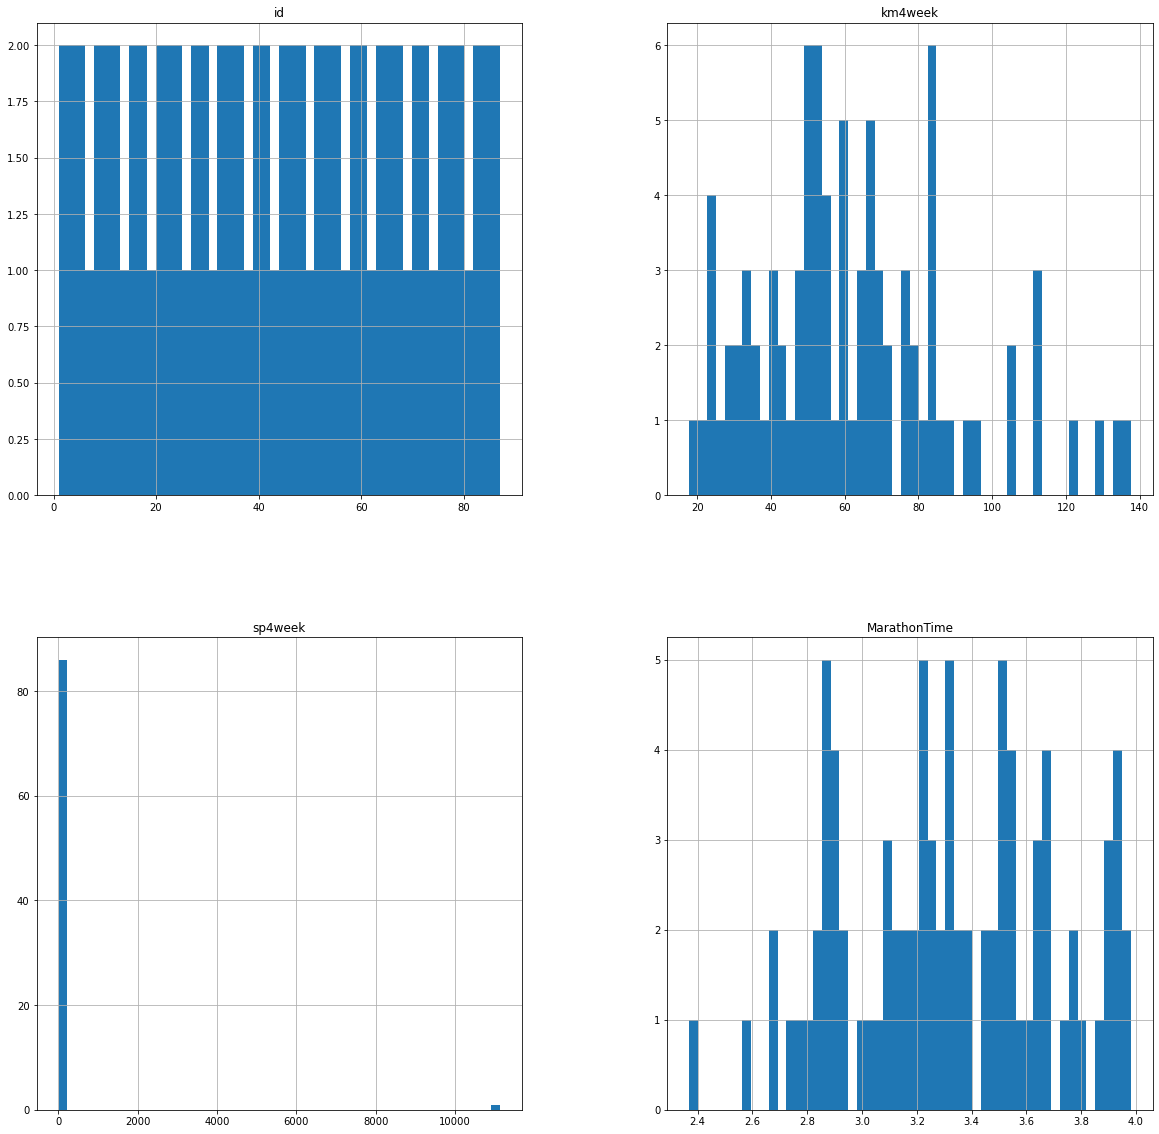

In [6]:
# visualize the data
marathon_data.hist(bins=50, figsize=(20,20));

* km4week has the largest predictive value to predict the marathon time.

## P4) Custom Transformer

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

km4week_ix, sp4week_ix = 0, 1

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_km4week_per_sp4week=True):
        self.add_km4week_per_sp4week = add_km4week_per_sp4week
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_km4week_per_sp4week:
            km4week_per_sp4week = X[:,km4week_ix] / X[:,sp4week_ix]
        return np.c_[X, km4week_per_sp4week]

## P5)
    Since km4week is the most predictive attribute, it should be stratified
    to maintain the prior probabilities of each category of km4week in the training
    and test sets.

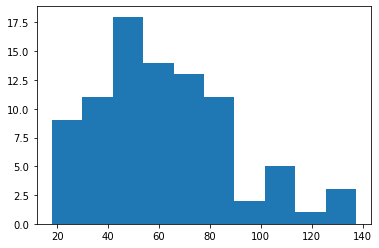

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# stratified partition for km4week
km4week_cat = pd.cut(marathon_data['km4week'],
                    bins=[0.,25.,50.,75.,100.,np.inf],
                    labels=[1, 2, 3, 4, 5])
plt.hist(marathon_data['km4week']);

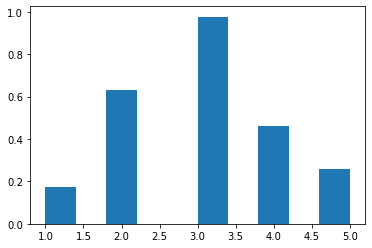

In [12]:


plt.hist(km4week_cat, density=True);

In [603]:
from sklearn.model_selection import train_test_split

# Partition data into training and test sets
train_set, test_set, km4_cat_train, km4_cat_test = train_test_split(marathon_data, 
                                                                    km4week_cat,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    stratify=km4week_cat,
                                                                    random_state=42);

In [604]:
train_set

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
47,48,Prague17,Miguel Escribano,M45,39.6,12.247423,NaN,1.67,3.35,B
43,44,Prague17,Filip Machart,MAM,32.2,12.710526,NaN,1.62,3.32,B
58,59,Prague17,Mark Orton,MAM,22.7,12.728972,NaN,1.67,3.52,C
59,60,Prague17,Hannes Lilljequist,M40,45.2,11.024390,NaN,1.77,3.52,C
63,64,Prague17,Bradley Selmes,MAM,20.7,12.420000,ciclista 5h,1.69,3.56,C
...,...,...,...,...,...,...,...,...,...,...
70,71,Prague17,Roy Bruhn,M45,87.0,11.472527,NaN,1.81,3.68,D
23,24,Prague17,Jiri Syrovatko,M45,66.1,12.128440,NaN,1.48,3.09,B
15,16,Prague17,David Lehnen,MAM,76.1,14.970492,NaN,1.45,2.90,A
76,77,Prague17,Michal Karhan,MAM,40.3,8.337931,ciclista 5h,1.94,3.80,D


In [605]:
test_set

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
65,66,Prague17,Barry Sacher,M45,60.3,11.708738,NaN,1.88,3.62,C
73,74,Prague17,Pavel Szappanos,NaN,53.6,12.711462,NaN,-,3.75,D
71,72,Prague17,Martin Bo Meyer,M50,24.2,11.523810,ciclista 3h,1.76,3.69,D
30,31,Prague17,Luka Slap?ak Pelliccioni,MAM,52.5,12.549801,ciclista 3h,1.62,3.19,B
55,56,Prague17,Jakub Ka?par,MAM,26.9,13.121951,NaN,1.67,3.50,C
64,65,Prague17,Frederic Bonningues,M40,54.2,11.782609,NaN,1.69,3.59,C
82,83,Prague17,Stefano Vegliani,M55,50.0,10.830325,NaN,2.02,3.93,D
31,32,Prague17,Ondrej Barta,MAM,79.4,13.344538,NaN,1.60,3.19,B
83,84,Prague17,Andrej Madliak,M40,33.6,10.130653,ciclista 3h,1.94,3.93,D
62,63,Prague17,Ale? Kuchynka,M45,48.8,11.665339,NaN,1.66,3.56,C


In [606]:
# Prepare data for ML algorithms
# training labels
t_train = train_set['MarathonTime'].copy()

# input data
X_train = train_set.drop(labels='MarathonTime', axis=1)
t_train.shape, X_train.shape

((69,), (69, 9))

In [607]:
# test labels
t_test = test_set['MarathonTime'].copy()

# input data
X_test = test_set.drop(labels='MarathonTime', axis=1)
t_test.shape, X_test.shape

((18,), (18, 9))

In [608]:
# Clean Data

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 47 to 38
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             69 non-null     int64  
 1   Marathon       69 non-null     object 
 2   Name           69 non-null     object 
 3   Category       64 non-null     object 
 4   km4week        69 non-null     float64
 5   sp4week        69 non-null     float64
 6   CrossTraining  10 non-null     object 
 7   Wall21         69 non-null     object 
 8   CATEGORY       69 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.4+ KB


I noticed on the data sheet that id values 26, 35, 52,54, 74, and 81 have '- 'values for Wall21 attributes, which aren't identified as NaN, causing issues when pipelining by category/numerical attributes later on. In order to fix this, it is best to convert the data type of Wall21 to 
float and then replace '- ' with NaN before using SimpleImputer to replace all NaN values.

In [609]:
X_train['Wall21'] = pd.to_numeric(X_train['Wall21'], errors='coerce')
X_test['Wall21'] = pd.to_numeric(X_test['Wall21'], errors='coerce')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 47 to 38
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             69 non-null     int64  
 1   Marathon       69 non-null     object 
 2   Name           69 non-null     object 
 3   Category       64 non-null     object 
 4   km4week        69 non-null     float64
 5   sp4week        69 non-null     float64
 6   CrossTraining  10 non-null     object 
 7   Wall21         64 non-null     float64
 8   CATEGORY       69 non-null     object 
dtypes: float64(3), int64(1), object(5)
memory usage: 5.4+ KB


As mentioned before, CrossTraining is missing more than half of its
samples so it should be dropped. The 'id','Marathon', and 'Name' attributes
don't contribute to predicting the Marathon Time, so they should also 
be dropped

In [610]:
X_train = X_train.drop(['id','CrossTraining','Marathon', 'Name'], axis=1);


X_test = X_test.drop(['id','CrossTraining','Marathon', 'Name'], axis=1);

Since the 'Category' attribute is only missing a few samples,
it would be best to replace the empty samples with the most 
frequent value using SimpleImputer

In [611]:
from sklearn.impute import SimpleImputer 

# learns the most frequent value for all columns with NaN
imputer = SimpleImputer(strategy='most_frequent')

In [612]:
Xtr = imputer.fit_transform(X_train)
Xts = imputer.transform(X_test)

In [613]:
imputer.statistics_

array(['MAM', 50.1, 8.031413613, 1.67, 'B'], dtype=object)

In [614]:
marathon_data_tr = pd.DataFrame(Xtr, columns=X_train.columns,
                               index=X_train.index)
marathon_data_tr

,Category,km4week,sp4week,Wall21,CATEGORY
47,M45,39.6,12.247423,1.67,B
43,MAM,32.2,12.710526,1.62,B
58,MAM,22.7,12.728972,1.67,C
59,M40,45.2,11.02439,1.77,C
63,MAM,20.7,12.42,1.69,C
...,...,...,...,...,...
70,M45,87.0,11.472527,1.81,D
23,M45,66.1,12.12844,1.48,B
15,MAM,76.1,14.970492,1.45,A
76,MAM,40.3,8.337931,1.94,D


In [615]:
# Convert data types of km4week, sp4week and Wall21 to float
marathon_data_tr['km4week'] = marathon_data_tr['km4week'].astype(float)
marathon_data_tr['sp4week'] = marathon_data_tr['sp4week'].astype(float)
marathon_data_tr['Wall21'] = marathon_data_tr['Wall21'].astype(float)

marathon_data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 47 to 38
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  69 non-null     object 
 1   km4week   69 non-null     float64
 2   sp4week   69 non-null     float64
 3   Wall21    69 non-null     float64
 4   CATEGORY  69 non-null     object 
dtypes: float64(3), object(2)
memory usage: 3.2+ KB


In [616]:
marathon_data_test = pd.DataFrame(Xts, columns=X_test.columns,
                               index=X_test.index)
marathon_data_test

,Category,km4week,sp4week,Wall21,CATEGORY
65,M45,60.3,11.708738,1.88,C
73,MAM,53.6,12.711462,1.67,D
71,M50,24.2,11.52381,1.76,D
30,MAM,52.5,12.549801,1.62,B
55,MAM,26.9,13.121951,1.67,C
64,M40,54.2,11.782609,1.69,C
82,M55,50.0,10.830325,2.02,D
31,MAM,79.4,13.344538,1.6,B
83,M40,33.6,10.130653,1.94,D
62,M45,48.8,11.665339,1.66,C


In [617]:
# Convert data types of km4week, sp4week and Wall21 to float
marathon_data_test['km4week'] = marathon_data_test['km4week'].astype(float)
marathon_data_test['sp4week'] = marathon_data_test['sp4week'].astype(float)
marathon_data_test['Wall21'] = marathon_data_test['Wall21'].astype(float)

marathon_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 65 to 68
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  18 non-null     object 
 1   km4week   18 non-null     float64
 2   sp4week   18 non-null     float64
 3   Wall21    18 non-null     float64
 4   CATEGORY  18 non-null     object 
dtypes: float64(3), object(2)
memory usage: 864.0+ bytes


## 6) Transformation Pipeline to encode categorical attributes

In [618]:
from sklearn.preprocessing import OneHotEncoder
# Collect all categorical attributes by dropping numerical attributes
X_train_cat = marathon_data_tr.drop(labels=['km4week','sp4week','Wall21'], axis=1)
X_test_cat = marathon_data_test.drop(labels=['km4week','sp4week','Wall21'], axis=1)


In [619]:
X_test_cat

,Category,CATEGORY
65,M45,C
73,MAM,D
71,M50,D
30,MAM,B
55,MAM,C
64,M40,C
82,M55,D
31,MAM,B
83,M40,D
62,M45,C


In [620]:
cat_encoder = OneHotEncoder()

X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)
X_test_cat_1hot = cat_encoder.transform(X_test_cat)

In [621]:
X_train_cat_1hot

<69x10 sparse matrix of type '<class 'numpy.float64'>'
	with 138 stored elements in Compressed Sparse Row format>

In [622]:
X_test_cat_1hot

<18x10 sparse matrix of type '<class 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>

In [623]:
X_train_cat_1hot.toarray()

array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 

In [624]:
X_test_cat_1hot.toarray()

array([[0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]])

In [625]:
cat_encoder.categories_

[array(['M40', 'M45', 'M50', 'M55', 'MAM', 'WAM'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

## 7) Transformation Pipeline to encode numerical attributes

In [626]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Drop all non-numerical attributes for training and test sets

marathon_data_num_tr = marathon_data_tr.drop(labels=['Category', 'CATEGORY'], axis=1)
marathon_data_num_test = marathon_data_test.drop(labels=['Category', 'CATEGORY'], axis=1)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler())])

marathon_num_tr = num_pipeline.fit_transform(marathon_data_num_tr)
marathon_num_test = num_pipeline.transform(marathon_data_num_test)
marathon_num_tr

array([[-0.87592143,  0.05825006,  0.2958742 , -0.9043226 ],
       [-1.15807744,  0.43192303,  0.04445401, -1.23534784],
       [-1.52030474,  0.44680661,  0.2958742 , -1.59001775],
       [-0.66239797, -0.92860068,  0.7987146 , -0.49448181],
       [-1.59656312,  0.1975007 ,  0.39644228, -1.64518863],
       [-0.39168072, -0.37623311,  1.65354327, -0.32108764],
       [ 1.89988359,  0.08788734, -0.15668215,  1.8936289 ],
       [ 1.65585677,  0.41908097, -1.01151082,  1.51531433],
       [ 1.89607067,  0.33821601, -0.8606587 ,  1.78328715],
       [-0.34592569,  1.53608616, -1.21264698, -0.63634978],
       [ 0.83607919,  0.30199675, -0.81037466,  0.75080364],
       [-0.93311522, -0.91319878,  0.2958742 , -0.8018624 ],
       [ 0.28320594,  1.28719693, -1.16236294, -0.02947016],
       [-0.77678554,  1.16004053, -1.46406718, -0.96737503],
       [-1.21908414, -0.89967315,  1.80439539, -1.12500609],
       [ 0.76744665, -0.4255081 ,  0.84899864,  0.92419782],
       [-1.00174776, -0.

In [627]:
marathon_num_test

array([[-8.66472025e-02, -3.76408499e-01,  1.35183903e+00,
         2.05605817e-03],
       [-3.42112775e-01,  4.32678384e-01,  2.95874203e-01,
        -4.39310939e-01],
       [-1.46311096e+00, -5.25625039e-01,  7.48430558e-01,
        -1.44026823e+00],
       [-3.84054883e-01,  3.02235467e-01,  4.44540059e-02,
        -4.55074047e-01],
       [-1.36016214e+00,  7.63897028e-01,  2.95874203e-01,
        -1.46391290e+00],
       [-3.19235261e-01, -3.16802972e-01,  3.96442282e-01,
        -2.58035209e-01],
       [-4.79377858e-01, -1.08518976e+00,  2.05581558e+00,
        -2.50153655e-01],
       [ 6.41620324e-01,  9.43499583e-01, -5.61140730e-02,
         3.80370625e-01],
       [-1.10469657e+00, -1.64974672e+00,  1.65354327e+00,
        -8.64914830e-01],
       [-5.25132886e-01, -4.11426820e-01,  2.45590163e-01,
        -4.55074047e-01],
       [ 5.42484430e-01,  6.20165183e-01, -8.60658704e-01,
         3.72489073e-01],
       [ 2.85692625e+00,  6.72235841e-02, -1.46406718e+00,
      

## 8) Transformation pipeline that combines both categorical and numerical attributes

In [628]:
from sklearn.compose import ColumnTransformer

# numerical columns
marathon_data_num_tr.columns

Index(['km4week', 'sp4week', 'Wall21'], dtype='object')

In [629]:
# categorial columns
X_train_cat.columns

Index(['Category', 'CATEGORY'], dtype='object')

In [630]:
num_attribs = list(marathon_data_num_tr.columns)
cat_attribs = list(X_train_cat.columns)

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', OneHotEncoder(), cat_attribs)])

X_train_prepared = full_pipeline.fit_transform(X_train)

X_test_prepared = full_pipeline.transform(X_test)

In [631]:
X_train_prepared.shape, X_test_prepared.shape

((69, 15), (18, 15))

In [632]:
attribute_labels = np.hstack((marathon_data_tr.columns, cat_encoder.categories_[0],cat_encoder.categories_[1]))
attribute_labels

array(['Category', 'km4week', 'sp4week', 'Wall21', 'CATEGORY', 'M40',
       'M45', 'M50', 'M55', 'MAM', 'WAM', 'A', 'B', 'C', 'D'],
      dtype=object)

In [633]:
marathon_data_train_prepared = pd.DataFrame(X_train_prepared,
                                            columns=attribute_labels,
                                           index=marathon_data_tr.index)
marathon_data_train_prepared

,Category,km4week,sp4week,Wall21,CATEGORY,M40,M45,M50,M55,MAM,WAM,A,B,C,D
47,-0.875921,0.058250,0.324276,-0.904323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43,-1.158077,0.431923,0.072021,-1.235348,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
58,-1.520305,0.446807,0.324276,-1.590018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
59,-0.662398,-0.928601,0.828787,-0.494482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63,-1.596563,0.197501,0.425179,-1.645189,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.931402,-0.567004,1.030592,1.152763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23,0.134502,-0.037755,-0.634295,0.143924,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0.515794,2.255463,-0.785648,-0.029470,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
76,-0.849231,-3.096274,1.686456,-0.147693,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [634]:
marathon_data_test_prepared = pd.DataFrame(X_test_prepared,
                                            columns=attribute_labels,
                                           index=marathon_data_test.index)
marathon_data_test_prepared

,Category,km4week,sp4week,Wall21,CATEGORY,M40,M45,M50,M55,MAM,WAM,A,B,C,D
65,-0.086647,-0.376408,1.383750,0.002056,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73,-0.342113,0.432678,-0.054107,-0.439311,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
71,-1.463111,-0.525625,0.778336,-1.440268,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30,-0.384055,0.302235,0.072021,-0.455074,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
55,-1.360162,0.763897,0.324276,-1.463913,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
64,-0.319235,-0.316803,0.425179,-0.258035,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
82,-0.479378,-1.085190,2.090065,-0.250154,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31,0.641620,0.943500,-0.028881,0.380371,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
83,-1.104697,-1.649747,1.686456,-0.864915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
62,-0.525133,-0.411427,0.273825,-0.455074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___